# 1. 영어 Word2Vec

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [3]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x127e0f6d0>)

In [4]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [5]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [6]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


## Word2Vec 훈련

In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# 빈도수가 적은 단어는 학습하지 않음(min_count)
# sg=0은 CBOW, sg==1 Skip-gram

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8510966300964355), ('guy', 0.8175697922706604), ('boy', 0.7762268781661987), ('lady', 0.7604398131370544), ('gentleman', 0.7487420439720154), ('girl', 0.7393457293510437), ('soldier', 0.7350847125053406), ('kid', 0.7066764235496521), ('poet', 0.6771904826164246), ('david', 0.6675728559494019)]


In [10]:
model.wv.save_word2vec_format('eng_w2v')

# # 모델 로드
# loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")

In [13]:
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")

In [14]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8510966300964355), ('guy', 0.8175697922706604), ('boy', 0.7762268781661987), ('lady', 0.7604398131370544), ('gentleman', 0.7487420439720154), ('girl', 0.7393457293510437), ('soldier', 0.7350847125053406), ('kid', 0.7066764235496521), ('poet', 0.6771904826164246), ('david', 0.6675728559494019)]


In [16]:
model_result = model.wv.most_similar("companies")
model_result

[('organizations', 0.8248206973075867),
 ('businesses', 0.7758809328079224),
 ('institutions', 0.7617282271385193),
 ('jobs', 0.754237949848175),
 ('groups', 0.7492644786834717),
 ('farmers', 0.7377856373786926),
 ('programs', 0.7311861515045166),
 ('teams', 0.713786244392395),
 ('governments', 0.7130589485168457),
 ('services', 0.7121625542640686)]

# 2. 한국어 Word2Vec

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [18]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x127f26580>)

In [19]:
train_data = pd.read_table('ratings.txt')

In [20]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [23]:
print('데이터의 개수 : ', len(train_data))

데이터의 개수 :  200000


In [24]:
# 결측값이 존재함
train_data.isnull().values.any()

True

In [25]:
# 결측값 처리 작업
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [26]:
print('잔여 데이터 개수 : ', len(train_data))

잔여 데이터 개수 :  199992


In [27]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [28]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [33]:
from tqdm import tqdm

In [34]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    # 형태소 추출
    tokenized_sentence = okt.morphs(sentence, stem=True)
    # 불용어 제거
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████████████████████████████| 199992/199992 [06:47<00:00, 490.67it/s]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


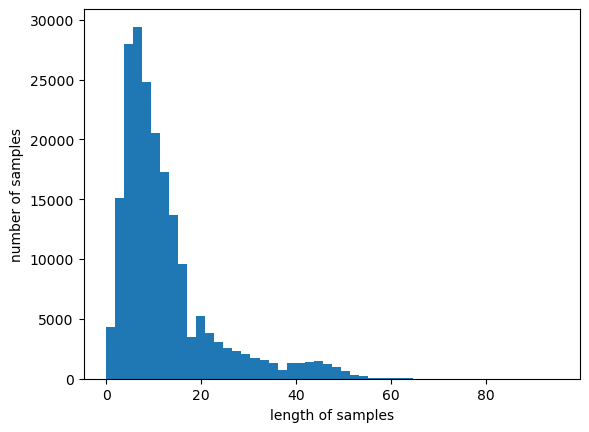

In [36]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [38]:
# 완성된 임베딩 매트릭스의 크기 확인
# 16477개의 단어, 각 단어는 100차원으로 구성
model.wv.vectors.shape

(17615, 100)

In [39]:
print(model.wv.most_similar("이병헌"))

[('김명민', 0.827461302280426), ('이정재', 0.8115682005882263), ('안성기', 0.8061765432357788), ('박상민', 0.7989981770515442), ('전도연', 0.7944896817207336), ('메릴', 0.783226728439331), ('정재영', 0.7830618619918823), ('스트립', 0.7792145013809204), ('숀펜', 0.778386652469635), ('김승우', 0.7777154445648193)]
